In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
sess = tf.InteractiveSession()
from tsfresh import extract_features, extract_relevant_features, select_features
from sklearn.tree import DecisionTreeClassifier
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters
from sklearn.cross_validation import train_test_split


c:\programdata\miniconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Simply classification

In [4]:
df1 = pd.read_csv('sub_17_dws1.csv')
df2 = pd.read_csv('sub_17_dws2.csv')
df3 = pd.read_csv('sub_17_dws11.csv')

df_1 = pd.concat([df1,df2,df3], ignore_index=True)
df_1['label'] = 0

df1 = pd.read_csv('sub_1_other.csv')
df2 = pd.read_csv('sub_1_other1.csv')
df3 = pd.read_csv('sub_1_other2.csv')

df_2 = pd.concat([df1,df2,df3], ignore_index=True)
df_2['label'] = 1

df = pd.concat([df_1,df_2], ignore_index = True)
df = df.rename(columns={'Unnamed: 0':'time'})
df.time = df.time % 10
df['id'] = df.index // 10
df.head()

,time,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,label,id
0,0,-0.539307,-1.282739,-0.834903,-0.145892,0.958798,-0.243768,0.574913,-0.227875,0.264080,0.159869,-0.055615,-0.241691,0,0
1,1,-0.500842,-1.272873,-0.788139,-0.140945,0.955948,-0.257483,0.701012,-0.416879,0.267339,0.163787,-0.106949,-0.233698,0,0
2,2,-0.469471,-1.261617,-0.746499,-0.137659,0.952583,-0.271356,0.696994,-0.462266,0.165888,0.136195,-0.103493,-0.262091,0,0
3,3,-0.450277,-1.250670,-0.717919,-0.136956,0.949196,-0.283320,0.534291,-0.426214,0.082452,0.010018,-0.057884,-0.270910,0,0
4,4,-0.441678,-1.243099,-0.698533,-0.137583,0.946786,-0.290975,0.309406,-0.597002,0.097124,-0.035666,-0.058999,-0.284754,0,0


In [43]:
extraction_settings = ComprehensiveFCParameters()

In [44]:
X = extract_features(df, 
                     column_id='id', column_sort='time',
                     default_fc_parameters=extraction_settings,
                     impute_function= impute)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [05:29<00:00, 16.49s/it]
 'attitude.pitch__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'attitude.pitch__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 ... 'userAcceleration.z__fft_coefficient__coeff_9__attr_"imag"'
 'userAcceleration.z__fft_coefficient__coeff_9__attr_"real"'
 'userAcceleration.z__spkt_welch_density__coeff_8'] did not have any finite values. Filling with zeros.


In [50]:
y = pd.Series(df[['id', 'label']].drop_duplicates()['label'])
y.reset_index(inplace=True, drop=True)
y =y[:-1]
df =df.drop(['label'],axis=1)

In [49]:
X_filtered = extract_relevant_features(df, y, 
                                       column_id='id', column_sort='time',default_fc_parameters=extraction_settings)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [04:51<00:00, 14.59s/it]
 'attitude.pitch__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'attitude.pitch__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 ... 'userAcceleration.z__fft_coefficient__coeff_9__attr_"imag"'
 'userAcceleration.z__fft_coefficient__coeff_9__attr_"real"'
 'userAcceleration.z__spkt_welch_density__coeff_8'] did not have any finite values. Filling with zeros.


In [54]:
X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered, y, test_size=.3)

In [56]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
cl = DecisionTreeClassifier()
cl.fit(X_filtered_train, y_train)
print(classification_report(y_test, cl.predict(X_filtered_test)))

             precision    recall  f1-score   support

          0       0.92      0.85      0.89       185
          1       0.84      0.92      0.88       154

avg / total       0.89      0.88      0.88       339



## LSTM classification 

In [27]:
df4  =pd.read_csv('train_anomaly//sub_17.csv')
df4 = df4.rename(columns={'Unnamed: 0':'time'})

X_train = np.append(np.array(df2[:2450]).reshape(49, 50, 13), 
          np.array(df1[:1750]).reshape(35, 50, 13),
          axis=0)
X_test_anomaly = np.array(df4[:6950]).reshape(139, 50, 13)
X_test_normal  = np.array(df3[:850]).reshape(17, 50, 13)

input_width = X_train.shape[2]-1  # Number of data-dimensions in our signal


In [28]:
def make_dense_model(n_hiddens):
    """Constructs an n-layer fully-connected model
    
    Args:
        n_hiddens (list) : Number of cells in hidden layers
    """
    global sess, x, y_, y, loss, train_step
    
    tf.reset_default_graph()
    sess.close()
    sess = tf.InteractiveSession()

    with tf.variable_scope('anomaly'):
        x = tf.placeholder(tf.float32, [None, None, input_width])
        y_ = tf.placeholder(tf.float32, [None, None, input_width])
        
        h = x
        for n_hidden in n_hiddens:
            h = tf.layers.dense(inputs=h, units=n_hidden)
            
        y = tf.layers.dense(inputs=h, units=input_width, activation=None)

        loss = tf.reduce_sum(tf.square(y_ - y), axis=[1,2])
        train_step = tf.train.AdamOptimizer(1e-3).minimize(loss)

        init = tf.global_variables_initializer()
        sess.run(init)



In [29]:
def make_lstm_model(n_hidden):
    """Constructs a one-layer LSTM model
    
    Args:
        n_hidden (int) : Number of cells in the hidden layer
    """
    global sess, x, y_, y, loss, train_step
    
    tf.reset_default_graph()
    sess.close()
    sess = tf.InteractiveSession()

    with tf.variable_scope('anomaly'):
        x = tf.placeholder(tf.float32, [None, None, input_width])
        y_ = tf.placeholder(tf.float32, [None, None, input_width])
        rnn_cell = tf.contrib.rnn.LSTMCell(n_hidden, initializer = tf.contrib.layers.xavier_initializer())
        rnn_out, rnn_final_state = tf.nn.dynamic_rnn(rnn_cell, x, dtype=tf.float32)
        y = tf.layers.dense(inputs=rnn_out, units=input_width, activation=None)

        loss = tf.reduce_sum(tf.square(y_ - y), axis=[1,2])
        train_step = tf.train.AdamOptimizer().minimize(loss)

        init = tf.global_variables_initializer()
        sess.run(init)
    

In [30]:
def sample_batch(X, batch_size):
    """Samples one set of subsequences of length `seq_len` as inputs and another, 
    shifted by `pred_distance` as outputs
    """
    # Sample a subset of signal sequences
    seq_idx = np.random.choice(X.shape[0], size=batch_size)
    # Sample starting positions in those sequences
    start_idx = np.random.choice(X.shape[1]-seq_len-pred_distance, size=batch_size)
    seqs = X[seq_idx, :, 1:]
    # Gather input and oredicted samples
    batch_x = np.array([seq[idx : idx+seq_len] for seq, idx in zip(seqs, start_idx)])
    batch_y = np.array([seq[idx+pred_distance : idx+pred_distance+seq_len] for seq, idx in zip(seqs, start_idx)])
    return batch_x, batch_y
    
    
def train_model(epochs):
    """Train the initialized model for `epochs`"""
    loss_history = []
    report_freq = 50  # Report the loss every _ epochs
    for epoch in np.arange(epochs):
        # Number of iterations per epoch is roughly number_of_sequences*batch_size
        n_iter = int(np.ceil(float(X_train.shape[0]) / batch_size))
        for i in np.arange(n_iter):
            batch_x, batch_y = sample_batch(X_train, batch_size)
            step_loss, y_pred, _ = sess.run([loss, y, train_step], feed_dict={x: batch_x, y_: batch_y})
            loss_history.append(np.mean(step_loss))
        if epoch % report_freq == 0:
            print('epoch {}, loss {}'.format(epoch, np.mean(loss_history[(-report_freq*n_iter):])))
    return loss_history
    
    
batch_size = 16
seq_len = 16  # The length of sequences we'll sample
pred_distance = 1  # How far into the future the predicted frames are
    
# Create a model
# make_lstm_model(4)
# make_lstm_model([4])
# [64, 32, 16, 8]
make_dense_model([64, 32, 16, 8, 4])

# Train the model
_  = train_model(4000)

epoch 0, loss 218.5824432373047
epoch 50, loss 114.9984359741211
epoch 100, loss 56.06641387939453
epoch 150, loss 38.63166046142578
epoch 200, loss 34.13804626464844
epoch 250, loss 33.028846740722656
epoch 300, loss 32.936336517333984
epoch 350, loss 32.1065673828125
epoch 400, loss 32.756561279296875
epoch 450, loss 31.91412353515625
epoch 500, loss 32.5394401550293
epoch 550, loss 32.090240478515625
epoch 600, loss 33.017372131347656
epoch 650, loss 32.1280403137207
epoch 700, loss 32.45460891723633
epoch 750, loss 32.34120559692383
epoch 800, loss 32.51811981201172
epoch 850, loss 32.506500244140625
epoch 900, loss 32.660709381103516
epoch 950, loss 32.14726638793945
epoch 1000, loss 31.873857498168945
epoch 1050, loss 32.10218811035156
epoch 1100, loss 32.13444900512695
epoch 1150, loss 32.06526565551758
epoch 1200, loss 32.50137710571289
epoch 1250, loss 32.83871841430664
epoch 1300, loss 32.0267219543457
epoch 1350, loss 32.05936050415039
epoch 1400, loss 31.957412719726562
epo

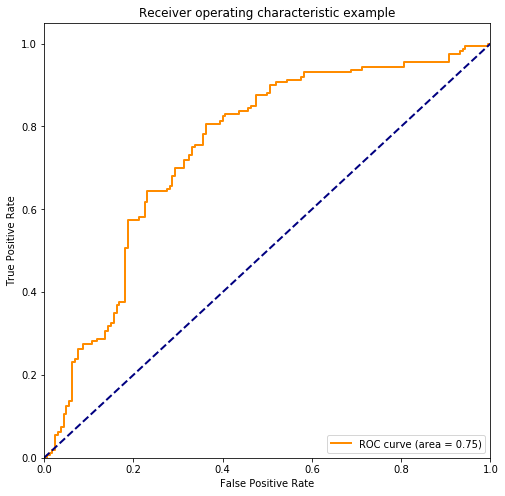

In [31]:
from sklearn.metrics import roc_curve, auc


def predict_loss(X, n_batches):
    """Samples and tries to predict `n_batches*batch_size` sequences from the X dataset
    
    Returns:
        losses (list) : Losses for each samples sequence
    """
    losses = []
    for i in np.arange(n_batches):
        batch_x, batch_y = sample_batch(X, batch_size)
        step_loss, y_pred = sess.run([loss, y], feed_dict={x: batch_x, y_: batch_y})
        losses.extend(step_loss)
    return losses


def roc(normal_loss, anomaly_loss):
    """Plot the ROC curve"""
    fpr, tpr, thresholds = roc_curve([0]*len(normal_loss) + [1]*len(anomaly_loss), normal_loss + anomaly_loss)
    roc_auc = auc(fpr, tpr)

    fig, ax = plt.subplots(figsize=(8, 8))
    lw = 2
    ax.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    ax.legend(loc="lower right")
    
    
# Get predictions loss for normal test data
normal_loss = predict_loss(X_test_normal, 10)
# print(normal_loss)

# Get predictions loss for anomalous test data
anomaly_loss = predict_loss(X_test_anomaly, 10)
# print(anomaly_loss)

# See how well we can distinguish  normal data from anomaluos one
roc(normal_loss, anomaly_loss)